## Predicting Survival on the Titanic

### History
Perhaps one of the most infamous shipwrecks in history, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 people on board. Interestingly, by analysing the probability of survival based on few attributes like gender, age, and social status, we can make very accurate predictions on which passengers would survive. Some groups of people were more likely to survive than others, such as women, children, and the upper-class. Therefore, we can learn about the society priorities and privileges at the time.

### Assignment:

Build a Machine Learning Pipeline, to engineer the features in the data set and predict who is more likely to Survive the catastrophe.

Follow the Jupyter notebook below, and complete the missing bits of code, to achieve each one of the pipeline steps.

In [329]:
import re

# to handle datasets
import pandas as pd
import numpy as np

# for visualization
import matplotlib.pyplot as plt
%matplotlib inline

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import StandardScaler

# to build the models
from sklearn.linear_model import LogisticRegression

# to evaluate the models
from sklearn.metrics import accuracy_score, roc_auc_score

# to persist the model and the scaler
import joblib

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

## Prepare the data set

In [330]:
# load the data - it is available open source and online

data = pd.read_csv('https://www.openml.org/data/get_csv/16826755/phpMYEkMl')

# display data
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,?,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,?,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,?,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"


In [331]:
# Print the shape of the dataset
data.shape

(1309, 14)

In [332]:
# replace interrogation marks by NaN values

data = data.replace('?', np.nan)

In [333]:
# asses the cabin column: there are missing values in 'cabin' column --> the reason why the next fct use try and except
data['cabin'].isnull().sum()

1014

In [334]:
# Find The most important cabin
cabin_list = [elts.split() for elts in data['cabin'] if type(elts)==str]
#cabine_list_2 = []
#for elt_1 in cabin_list:
#    for elt_2 in elt_1:
#        cabine_list_2.append(elt_2)
#
#cabine_list_2
pd.Series([elt_2 for elt_1 in cabin_list for elt_2 in elt_1]).value_counts(ascending=False)

F       8
C25     6
C23     6
C27     6
B63     5
       ..
B37     1
C132    1
E60     1
B56     1
F38     1
Length: 202, dtype: int64

In [335]:
# retain only the first cabin if more than
# 1 are available per passenger: Because there is more than just one cabine in some cells

def get_first_cabin(row):
    try:
        return row.split()[0]
    except:
        return np.nan
    
data['cabin'] = data['cabin'].apply(get_first_cabin)

# print the result
data.head(3)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [336]:
# extracts the title (Mr, Ms, etc) from the name variable

def get_title(passenger):
    line = passenger
    if re.search('Mrs', line):
        return 'Mrs'
    elif re.search('Mr', line):
        return 'Mr'
    elif re.search('Miss', line):
        return 'Miss'
    elif re.search('Master', line):
        return 'Master'
    else:
        return 'Other'
    
data['title'] = data['name'].apply(get_title)

In [337]:
# cast numerical variables as floats

data['fare'] = data['fare'].astype('float')
data['age'] = data['age'].astype('float')

In [338]:
# drop unnecessary variables

data.drop(labels=['name','ticket', 'boat', 'body','home.dest'], axis=1, inplace=True)

# display data
data.head()

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,title
0,1,1,female,29.0000,0,0,211.3375,B5,S,Miss
1,1,1,male,0.9167,1,2,151.5500,C22,S,Master
2,1,0,female,2.0000,1,2,151.5500,C22,S,Miss
3,1,0,male,30.0000,1,2,151.5500,C22,S,Mr
4,1,0,female,25.0000,1,2,151.5500,C22,S,Mrs


In [339]:
# save the data set

data.to_csv('titanic.csv', index=False)

## Data Exploration

### Find numerical and categorical variables

In [340]:
# target variable
target = 'survived'

In [341]:
# Categorical varriable
print( 'method 1: ', [col for col in data.columns if len(data[col].unique()) < 20])
print('method 2: ', data.select_dtypes(include=['object']).columns.tolist())

method 1:  ['pclass', 'survived', 'sex', 'sibsp', 'parch', 'embarked', 'title']
method 2:  ['sex', 'cabin', 'embarked', 'title']


In [342]:
# numerical variable
print('method 2: ', data.select_dtypes(include=['float', 'int']).columns.tolist())

method 2:  ['pclass', 'survived', 'age', 'sibsp', 'parch', 'fare']


In [343]:
vars_num = [col for col in data.select_dtypes(include=['float', 'int']).columns if col != target]

vars_cat = data.select_dtypes(include=['object']).columns.tolist()

print('Number of numerical variables: {}'.format(len(vars_num)))
print('Number of categorical variables: {}'.format(len(vars_cat)))

Number of numerical variables: 5
Number of categorical variables: 4


### Find missing values in variables

In [344]:
# first in numerical variables
missing_vars_num = [var for var in data[vars_num] if data[var].isnull().sum()> 0]
missing_vars_num

['age', 'fare']

In [345]:
# now in categorical variables
missing_vars_cat = [var for var in data[vars_cat] if data[var].isnull().sum()> 0]
missing_vars_cat

['cabin', 'embarked']

### Determine cardinality of categorical variables

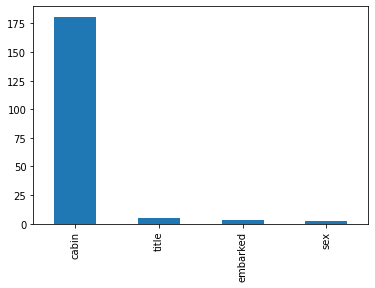

In [346]:
data[vars_cat].nunique().sort_values(ascending=False).plot.bar();

### Determine the distribution of numerical variables

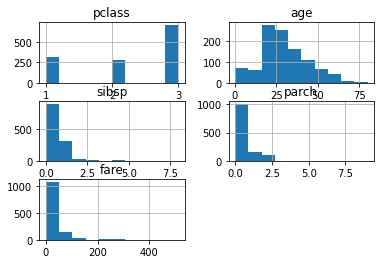

In [347]:
data[vars_num].hist();

## Separate data into train and test

Use the code below for reproducibility. Don't change it.

In [348]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('survived', axis=1),  # predictors
    data['survived'],  # target
    test_size=0.2,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((1047, 9), (262, 9))

## Feature Engineering

### Extract only the letter (and drop the number) from the variable Cabin

In [349]:
def extract_1st_letter(elt):
    """Extract the first letter of the cabin"""
    try: 
        extract = re.search(r'[A-Z]', elt)
        return extract.group()
    except:
        return np.nan
#
X_train.cabin = X_train.cabin.apply(extract_1st_letter)
X_test.cabin = X_test.cabin.apply(extract_1st_letter)

X_train.head()

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title
1118,3,male,25.0,0,0,7.9250,NaN,S,Mr
44,1,female,41.0,0,0,134.5000,E,C,Miss
1072,3,male,NaN,0,0,7.7333,NaN,Q,Mr
1130,3,female,18.0,0,0,7.7750,NaN,S,Miss
574,2,male,29.0,1,0,21.0000,NaN,S,Mr


### Fill in Missing data in numerical variables:

- Add a binary missing indicator
- Fill NA in original variable with the median

In [350]:
# utility function for imputation
def impute_numerical(df, colname):
    # copy of the dataframe
    df = df.copy()
    # compute the median:
    median_val = df[colname].median()
    # create the missing value indicator in the df
    df[colname + '_na_indicator'] = np.where(df[colname].isnull(), 1, 0)
    # imput missing value
    df[colname] = df[colname].fillna(median_val)
    return df

# function application
for col_name in missing_vars_num:
    X_train = impute_numerical(X_train, col_name)

# show results
X_train.head()

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title,age_na_indicator,fare_na_indicator
1118,3,male,25.0,0,0,7.9250,NaN,S,Mr,0,0
44,1,female,41.0,0,0,134.5000,E,C,Miss,0,0
1072,3,male,28.0,0,0,7.7333,NaN,Q,Mr,1,0
1130,3,female,18.0,0,0,7.7750,NaN,S,Miss,0,0
574,2,male,29.0,1,0,21.0000,NaN,S,Mr,0,0


In [351]:
# sanity check
X_train[missing_vars_num].isna().sum()

age     0
fare    0
dtype: int64

In [352]:
# function application
for col_name in missing_vars_num:
    X_test = impute_numerical(X_test, col_name)

# show results
X_test.head()

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title,age_na_indicator,fare_na_indicator
1139,3,male,38.0,0,0,7.8958,NaN,S,Mr,0,0
533,2,female,21.0,0,1,21.0000,NaN,S,Miss,0,0
459,2,male,42.0,1,0,27.0000,NaN,S,Mr,0,0
1150,3,male,26.0,0,0,14.5000,NaN,S,Mr,1,0
393,2,male,25.0,0,0,31.5000,NaN,S,Mr,0,0


In [353]:
# sanity check
X_test[missing_vars_num].isna().sum()

age     0
fare    0
dtype: int64

### Replace Missing data in categorical variables with the string **Missing**

In [354]:
X_train[missing_vars_cat] = X_train[missing_vars_cat].fillna('Missing')
X_train.head()

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title,age_na_indicator,fare_na_indicator
1118,3,male,25.0,0,0,7.9250,Missing,S,Mr,0,0
44,1,female,41.0,0,0,134.5000,E,C,Miss,0,0
1072,3,male,28.0,0,0,7.7333,Missing,Q,Mr,1,0
1130,3,female,18.0,0,0,7.7750,Missing,S,Miss,0,0
574,2,male,29.0,1,0,21.0000,Missing,S,Mr,0,0


In [355]:
X_test[missing_vars_cat] = X_test[missing_vars_cat].fillna('Missing')
X_test.head()

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title,age_na_indicator,fare_na_indicator
1139,3,male,38.0,0,0,7.8958,Missing,S,Mr,0,0
533,2,female,21.0,0,1,21.0000,Missing,S,Miss,0,0
459,2,male,42.0,1,0,27.0000,Missing,S,Mr,0,0
1150,3,male,26.0,0,0,14.5000,Missing,S,Mr,1,0
393,2,male,25.0,0,0,31.5000,Missing,S,Mr,0,0


### Remove rare labels in categorical variables

- remove labels present in less than 5 % of the passengers

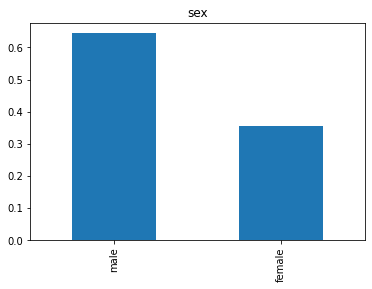

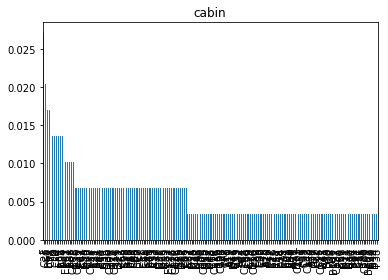

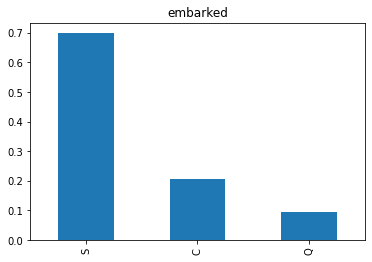

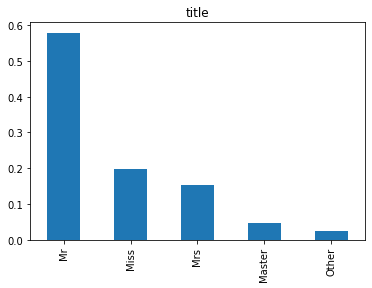

In [356]:
# Explore cat vars with rare actegories
for var in data[vars_cat].columns:
    #print(var)
    data[var].value_counts(normalize=True).plot.bar(title=var)
    plt.show() # necessary in the for loop

In [357]:
# Utility function
def find_frequent_labels(df, var, rare_perc):
    
    # function finds the labels that are shared by more than
    # a certain % of the houses in the dataset

    df = df.copy()

    #tmp = df.groupby(var)[var].count() / len(df)
    tmp = df[var].value_counts(normalize = True)

    return tmp[tmp > rare_perc].index # select most commun categories \ labels in the var column

#
freq = .05
find_frequent_labels(X_train, 'title', freq)

Index(['Mr', 'Miss', 'Mrs'], dtype='object')

In [358]:
# replace labels with less than 5% frequency
for var in vars_cat:
    
    # find the frequent categories
    frequent_ls = find_frequent_labels(X_train, var, freq)
    
    print(var, frequent_ls, '\n')
    #print()
    
    # replace rare categories by the string "Rare"
    X_train[var] = np.where(X_train[var].isin(
        frequent_ls), X_train[var], 'Rare')
    
    X_test[var] = np.where(X_test[var].isin(
        frequent_ls), X_test[var], 'Rare')

sex Index(['male', 'female'], dtype='object') 

cabin Index(['Missing', 'C'], dtype='object') 

embarked Index(['S', 'C', 'Q'], dtype='object') 

title Index(['Mr', 'Miss', 'Mrs'], dtype='object') 



In [359]:
# sanity check
X_train[vars_cat].nunique()

sex         2
cabin       3
embarked    4
title       4
dtype: int64

In [360]:
# sanity check
X_test[vars_cat].nunique()

sex         2
cabin       3
embarked    3
title       4
dtype: int64

### Perform one hot encoding of categorical variables into k-1 binary variables

- k-1, means that if the variable contains 9 different categories, we create 8 different binary variables
- Remember to drop the original categorical variable (the one with the strings) after the encoding

In [361]:
def hot_encdoding(df, colnames):
    df = df.copy()
    for var in colnames:
        df = pd.concat([df, pd.get_dummies(df[var], drop_first=True, prefix='dum_'+var)], axis=1)
        df.drop(columns=var, inplace=True)
    return df
#
X_train = hot_encdoding(X_train, vars_cat)
X_test = hot_encdoding(X_test, vars_cat)

print(X_train.shape, X_test.shape)

(1047, 16) (262, 15)


In [362]:
# Column not present in test set
miss_col_in_test = [var for var in X_train.columns if var not in X_test.columns]

In [363]:
# Add the missing col in the test set
for elt in miss_col_in_test:
    X_test[elt] = 0
# Sanity check
print(X_train.shape, X_test.shape)

(1047, 16) (262, 16)


In [374]:
print(X_train.columns)
print(X_test.columns)
if not all(X_train.columns == X_test.columns):
    print('\nThe columns are not in the same order')

Index(['pclass', 'age', 'sibsp', 'parch', 'fare', 'age_na_indicator',
       'fare_na_indicator', 'dum_sex_male', 'dum_cabin_Missing',
       'dum_cabin_Rare', 'dum_embarked_Q', 'dum_embarked_Rare',
       'dum_embarked_S', 'dum_title_Mr', 'dum_title_Mrs', 'dum_title_Rare'],
      dtype='object')
Index(['pclass', 'age', 'sibsp', 'parch', 'fare', 'age_na_indicator',
       'fare_na_indicator', 'dum_sex_male', 'dum_cabin_Missing',
       'dum_cabin_Rare', 'dum_embarked_Q', 'dum_embarked_S', 'dum_title_Mr',
       'dum_title_Mrs', 'dum_title_Rare', 'dum_embarked_Rare'],
      dtype='object')

The columns are not in the same order


In [375]:
# reorder the columns
col_order = X_train.columns.tolist()
X_test = X_test[col_order]
if not all(X_train.columns == X_test.columns):
    print('\nThe columns are not in the same order')
else:
    print('you can proceed')

you can proceed


### Scale the variables

- Use the standard scaler from Scikit-learn

In [376]:
# create scaler
scaler = StandardScaler()

#  fit  the scaler to the train set
scaler.fit(X_train) 

# transform the train and test set

# sklearn returns numpy arrays, so we wrap the
# array with a pandas dataframe

X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

In [377]:
X_train.head()

,pclass,age,sibsp,parch,fare,age_na_indicator,fare_na_indicator,dum_sex_male,dum_cabin_Missing,dum_cabin_Rare,dum_embarked_Q,dum_embarked_Rare,dum_embarked_S,dum_title_Mr,dum_title_Mrs,dum_title_Rare
0,0.835808,-0.370162,-0.478911,-0.455423,-0.504782,-0.494921,-0.03092,0.761042,0.551235,-0.434076,-0.319539,-0.043748,0.639650,0.869892,-0.435629,-0.275778
1,-1.542157,0.904029,-0.478911,-0.455423,1.971555,-0.494921,-0.03092,-1.313987,-1.814107,2.303742,-0.319539,-0.043748,-1.563355,-1.149569,-0.435629,-0.275778
2,0.835808,-0.131251,-0.478911,-0.455423,-0.508533,2.020526,-0.03092,0.761042,0.551235,-0.434076,3.129507,-0.043748,-1.563355,0.869892,-0.435629,-0.275778
3,0.835808,-0.927621,-0.478911,-0.455423,-0.507717,-0.494921,-0.03092,-1.313987,0.551235,-0.434076,-0.319539,-0.043748,0.639650,-1.149569,-0.435629,-0.275778
4,-0.353174,-0.051614,0.434422,-0.455423,-0.248980,-0.494921,-0.03092,0.761042,0.551235,-0.434076,-0.319539,-0.043748,0.639650,0.869892,-0.435629,-0.275778


## Train the Logistic Regression model

- Set the regularization parameter to 0.0005
- Set the seed to 0

## Make predictions and evaluate model performance

Determine:
- roc-auc
- accuracy

**Important, remember that to determine the accuracy, you need the outcome 0, 1, referring to survived or not. But to determine the roc-auc you need the probability of survival.**

That's it! Well done

**Keep this code safe, as we will use this notebook later on, to build production code, in our next assignement!!**